### import libraries

In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from model import DNN
from forward_config import *


### finite diffs solution for reference.

In [2]:
from reference import finite_diffs

P, uu, tt = finite_diffs(200, 50)

P = P / Pk

tt = tt/t_end

d:\Inverse_task\badertdinova_task\forward\reference.py:27: RuntimeWarning: overflow encountered in exp
  return (mu_h-mu_o) / (1 + np.exp(B * (1/np.exp(ux)*grad - G))) + mu_o


### train model

[0.0009000000000000001]
epoch 5000: loss 0.081385


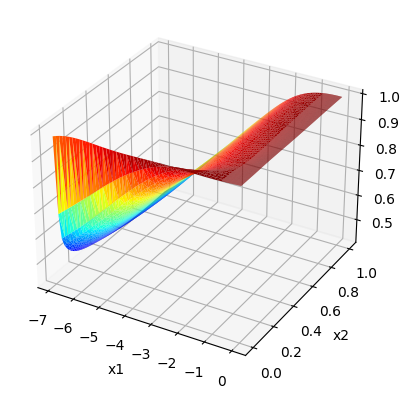

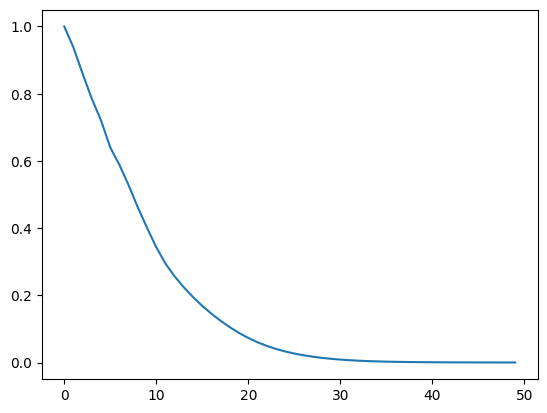

[0.0008100000000000001]
epoch 10000: loss 0.045255


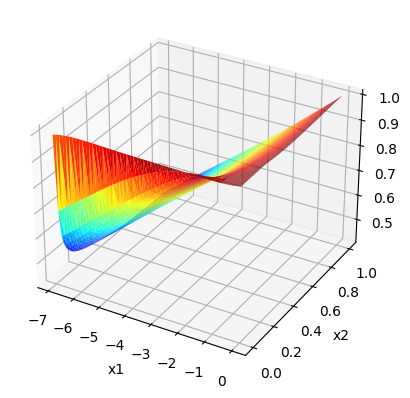

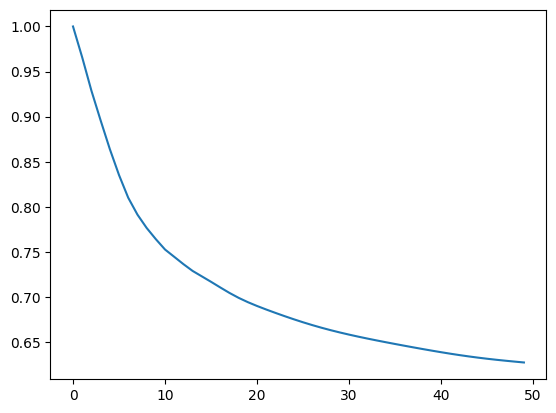

[0.000729]
epoch 15000: loss 0.034714


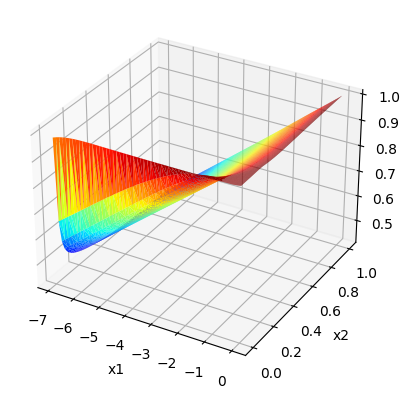

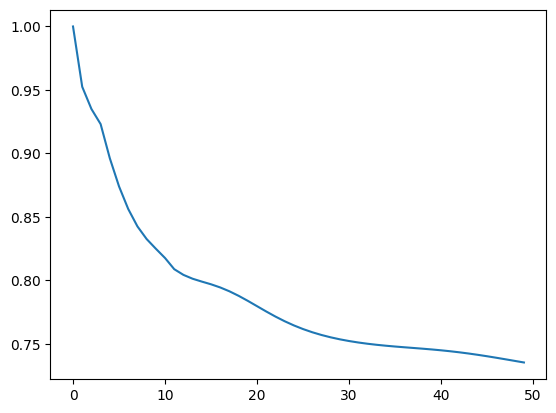

[0.0006561000000000001]
epoch 20000: loss 0.018541


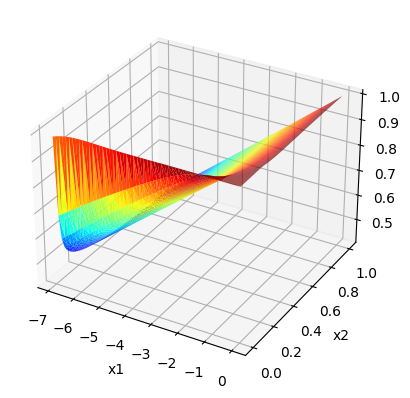

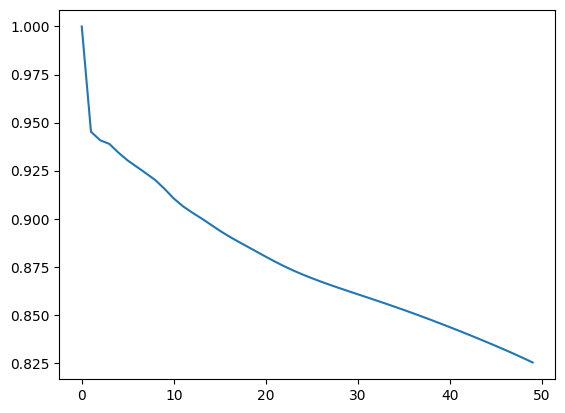

In [3]:
device = torch.device(device)
lr = 0.001
epochs = 20000


tol = 0.3
n_t = 50

u = torch.linspace(Rk/2/r0, Rk/r0, 70)
u = torch.log(u)

u1 = torch.linspace(np.log(rc/r0), np.log(Rk/2/r0), 50)
u = torch.hstack((u, u1[:-1]))
u = torch.sort(u)[0]

t = torch.linspace(t0, 1, n_t)

grid = torch.cartesian_prod(t, u).float().to(device)
grid = grid[grid[:, 0].argsort()]

# p(u,0)=1
bnd1 = torch.cartesian_prod(torch.tensor([0.]), u).float().to(device)
bndval1 = torch.tensor([1.]).to(device)

#bnd2(u(-1), t)=1
bnd2 = torch.cartesian_prod(t, torch.tensor([u[-1].item()])).float().to(device)
bndval2 = torch.tensor([1.]).to(device)

#bnd3
bnd3 = torch.cartesian_prod(t, torch.tensor([u[0].item()])).float().to(device)

tt = torch.from_numpy(tt).float()

bnd_data = torch.cartesian_prod(tt, torch.tensor([u[0].item()])).float().to(device)

bnd_value = torch.from_numpy(P[0,:]).float().to(device)

NN = nn.Sequential(
    nn.Linear(2, 200),
    nn.Tanh(),
    nn.Linear(200, 200),
    nn.Tanh(),
    nn.Linear(200, 200),
    nn.Tanh(),
    nn.Linear(200, 200),
    nn.Tanh(),
    nn.Linear(200, 200),
    nn.Tanh(),
    nn.Linear(200, 1)).to(device)


# Initialize neural network
model = DNN(NN, tol, n_t).to(device)

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Train PINNs
for epoch in range(1, epochs+1):
    model.train()

    def closure():
        global W
        optimizer.zero_grad()
        L_t, W = model.loss_weights(grid)
        loss_bnd1 = model.loss_dirichlet(bnd1, bndval1).reshape(-1)
        loss_bnd2 = model.loss_dirichlet(bnd2, bndval2).reshape(-1)
        loss_bnd3 = model.loss_operator(bnd3).reshape(-1)
        loss_bnd31 = model.loss_dirichlet(bnd_data, bnd_value).reshape(-1)
        loss = torch.mean(W*L_t) + 1000*(torch.hstack([loss_bnd1, loss_bnd2, loss_bnd3, loss_bnd31])).mean()
        loss.backward()
        return loss


    # Optimize loss function
    loss_pde = optimizer.step(closure)
    if epoch % 5000 == 0:
        scheduler.step()
        print(scheduler.get_last_lr())
    loss_value = loss_pde.item() if not isinstance(loss_pde, float) else loss_pde


    if epoch%5000==0:
        print(f'epoch {epoch}: loss {loss_value:.6f}')
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(projection='3d')
        ax1.plot_trisurf(grid[:, 1].cpu().detach().numpy().reshape(-1), grid[:, 0].cpu().detach().numpy().reshape(-1),
                    model(grid).cpu().detach().numpy().reshape(-1), cmap=cm.jet, linewidth=0.2, alpha=1)
        ax1.set_xlabel("x1")
        ax1.set_ylabel("x2")
        plt.show()
        plt.plot(W.detach().cpu().numpy())
        plt.show()



### graphs for comparing

<Figure size 640x480 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

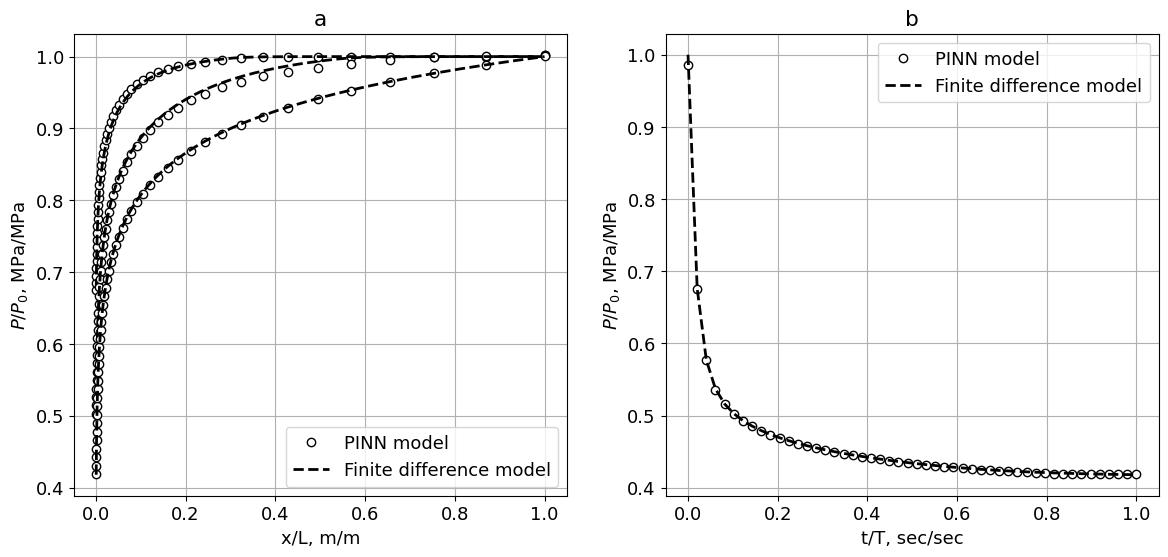

In [4]:
u = torch.linspace(np.log(rc/r0), np.log(Rk/r0), 50)
r = torch.exp(u)
t = torch.linspace(0, 1, 50)

grid1 = torch.cartesian_prod(torch.tensor([t[1].item()]), u).float().to(device)
grid2 = torch.cartesian_prod(torch.tensor([t[5].item()]), u).float().to(device)
grid3 = torch.cartesian_prod(torch.tensor([t[49].item()]), u).float().to(device)
gridt = torch.cartesian_prod(t, torch.tensor([u[0].item()])).float().to(device)

import matplotlib
plt.figure()
plt.figure(figsize=(14, 8))
font = {'serif' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(r, model(grid1).cpu().detach().numpy(),'o', c='k', mfc='w', mec='k',ms=6, label = 'PINN model')
ax1.plot(np.exp(uu)/r0, P[:,1], '--', c='k', lw=2, label = 'Finite difference model')
ax1.plot(r, model(grid2).cpu().detach().numpy(),'o', c='k', mfc='w', mec='k',ms=6)
ax1.plot(np.exp(uu)/r0, P[:,5], '--', c='k', lw=2)
ax1.plot(r, model(grid3).cpu().detach().numpy(), 'o', c='k', mfc='w', mec='k',ms=6)
ax1.plot(np.exp(uu)/r0, P[:,49], '--', c='k', lw=2)
ax1.set_xlabel('x/L, m/m')
ax1.set_ylabel('$P/P_0$, MPa/MPa')
ax1.set_title('a')
ax1.grid()
ax1.legend(loc='lower right')

ax2.plot(t, model(gridt).cpu().detach().numpy(),'o', c='k', mfc='w', mec='k',ms=6, label = 'PINN model')
ax2.plot(tt, P[0,:], '--', c='k', lw=2, label = 'Finite difference model')
ax2.set_xlabel('t/T, sec/sec')
ax2.set_ylabel('$P/P_0$, MPa/MPa')
ax2.legend(loc='upper right')
ax2.grid()
ax2.set_title('b')
# plt.savefig('PINN_FD_badertdinova.eps',dpi = 1000, bbox_inches='tight')
plt.show()


### Relative RMSE confidence

In [ ]:
from data_interp import fd_solution
from copy import copy

rel_rmse = []

for i in range(5):
    device = torch.device(device)
    lr = 0.001
    epochs = 20000
    tol = 0.3
    n_t = 50

    u = torch.linspace(Rk/2/r0, Rk/r0, 70)
    u = torch.log(u)

    u1 = torch.linspace(np.log(rc/r0), np.log(Rk/2/r0), 50)
    u = torch.hstack((u, u1[:-1]))
    u = torch.sort(u)[0]

    t = torch.linspace(t0, 1, n_t)

    grid = torch.cartesian_prod(t, u).float().to(device)
    grid = grid[grid[:, 0].argsort()]

    # p(u,0)=1
    bnd1 = torch.cartesian_prod(torch.tensor([0.]), u).float().to(device)
    bndval1 = torch.tensor([1.]).to(device)

    #bnd2(u(-1), t)=1
    bnd2 = torch.cartesian_prod(t, torch.tensor([u[-1].item()])).float().to(device)
    bndval2 = torch.tensor([1.]).to(device)

    #bnd3
    bnd3 = torch.cartesian_prod(t, torch.tensor([u[0].item()])).float().to(device)

    P, uu, tt = finite_diffs(200, 50)

    P = P / Pk

    tt = tt/t_end

    tt = torch.from_numpy(tt).float()

    bnd_data = torch.cartesian_prod(tt, torch.tensor([u[0].item()])).float().to(device)

    bnd_value = torch.from_numpy(P[0,:]).float().to(device)

    NN = nn.Sequential(
        nn.Linear(2, 200),
        nn.Tanh(),
        nn.Linear(200, 200),
        nn.Tanh(),
        nn.Linear(200, 200),
        nn.Tanh(),
        nn.Linear(200, 200),
        nn.Tanh(),
        nn.Linear(200, 200),
        nn.Tanh(),
        nn.Linear(200, 1)).to(device)

    model = DNN(NN, tol, n_t).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=0.9)

    for epoch in range(1, epochs+1):
        model.train()

        def closure():
            optimizer.zero_grad()
            L_t, W = model.loss_weights(grid)
            loss_bnd1 = model.loss_dirichlet(bnd1, bndval1).reshape(-1)
            loss_bnd2 = model.loss_dirichlet(bnd2, bndval2).reshape(-1)
            loss_bnd3 = model.loss_operator(bnd3).reshape(-1)
            loss_bnd31 = model.loss_dirichlet(bnd_data, bnd_value).reshape(-1)
            loss = torch.mean(W*L_t) + 1000*(torch.hstack([loss_bnd1, loss_bnd2, loss_bnd3, loss_bnd31])).mean()
            loss.backward()
            return loss

        # Optimize loss function
        loss_pde = optimizer.step(closure)
        if epoch % 5000 == 0:
            scheduler.step()

    pinn_sol = model(grid).detach().cpu().numpy().reshape(-1)

    grid_fd = copy(grid.detach().cpu())

    grid_fd[:,1] = torch.exp(grid_fd[:,1])

    fd_sol = fd_solution(grid_fd).reshape(-1)

    rmse = np.sqrt(np.sum((fd_sol - pinn_sol)**2)) / np.sqrt(np.sum(fd_sol**2))
    print("relative RMSE= ", rmse)
    rel_rmse.append(rmse)


In [ ]:
import scipy.stats as st 
 
# create 95% confidence interval 
conf_inerval = st.t.interval(confidence=0.95, df=len(rel_rmse)-1, 
                            loc=np.mean(rel_rmse), 
                            scale=st.sem(rel_rmse))

conf_inerval

## HEAT map

d:\Inverse_task\badertdinova_task\forward\reference.py:27: RuntimeWarning: overflow encountered in exp
  return (mu_h-mu_o) / (1 + np.exp(B * (1/np.exp(ux)*grad - G))) + mu_o


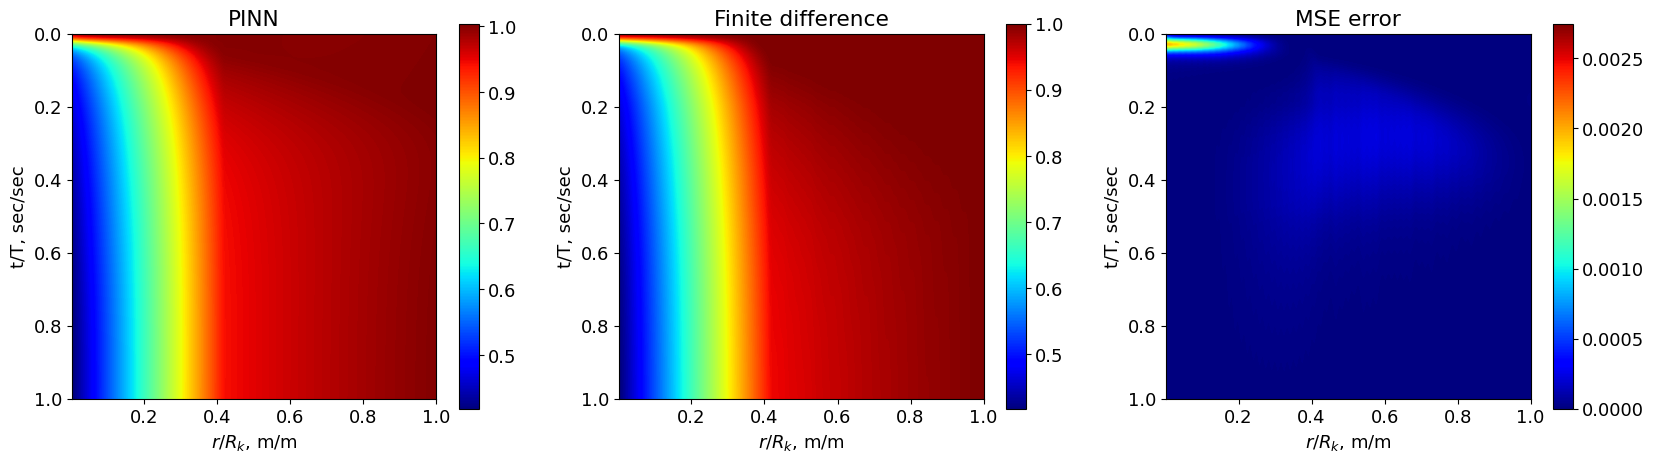

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from data_interp import fd_solution
from copy import copy

grid_fd = copy(grid.detach().cpu())

grid_fd[:,1] = torch.exp(grid_fd[:,1])

fd_sol = fd_solution(grid_fd.detach().cpu()).reshape(50, 119)

nn_sol = model(grid).detach().cpu().reshape(50, 119)

mse_error = (nn_sol-fd_sol)**2

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(20, 5))
im0 = ax0.imshow(nn_sol, cmap=cm.jet,  interpolation='bicubic', extent=[0.1/100, 1, 1, 0])
fig.colorbar(im0, ax=ax0)
ax0.set_title('PINN')
ax0.set_ylabel('t/T, sec/sec')
ax0.set_xlabel('$r/R_k$, m/m')

im1 = ax1.imshow(fd_sol, cmap=cm.jet, interpolation='bicubic', extent=[0.1/100, 1, 1, 0])
fig.colorbar(im1, ax=ax1)
ax1.set_title('Finite difference')
ax1.set_ylabel('t/T, sec/sec')
ax1.set_xlabel('$r/R_k$, m/m')

im2 = ax2.imshow(mse_error, cmap=cm.jet, interpolation='bicubic', extent=[0.1/100, 1, 1, 0])
fig.colorbar(im2, ax=ax2)
ax2.set_title('MSE error')
ax2.set_ylabel('t/T, sec/sec')
ax2.set_xlabel('$r/R_k$, m/m')
# plt.savefig('bader_triple.eps')
plt.show()